<a href="https://colab.research.google.com/github/Lemuca09/trabalho-rede-neural/blob/main/PrevisaoAcoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1042]:
import os
import json
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

**Configurações**

In [1043]:
TICKERS = ['AAPL', 'MSFT', 'GOOGL']
# TICKERS = ['GOOGL']
# TICKERS = ['NVDA', 'AMZN', 'META', 'ODD'] # Exemplo onde ODD tende a ser contrário aos outros valores no PCA
# TICKERS = ['NVDA', 'AMZN', 'META']
WINDOW_SIZE = 12  # 12 semanas (~3 meses)
EPOCHS = 300 # 300
BATCH_SIZE = 4

TRAIN = False # Controle para se for necessário retreinar

FUTURE_STEPS = 4  # número de semanas a prever

MODEL_PATH = "modelo_lstm_portfolio_acoes.h5"
HISTORY_PATH = "history_lstm.json"

**Baixar dados semanais dos últimos 3 anos**

In [1044]:
dfs = []
for ticker in TICKERS:
    data = yf.Ticker(ticker).history(period="3y", interval="1wk")['Close']
    data.name = ticker
    dfs.append(data)

len(data), data

(157,
 Date
 2022-06-06 00:00:00-04:00    110.632576
 2022-06-13 00:00:00-04:00    106.633682
 2022-06-20 00:00:00-04:00    117.413643
 2022-06-27 00:00:00-04:00    108.220100
 2022-07-04 00:00:00-04:00    118.785583
                                 ...    
 2025-05-05 00:00:00-04:00    152.750000
 2025-05-12 00:00:00-04:00    166.190002
 2025-05-19 00:00:00-04:00    168.470001
 2025-05-26 00:00:00-04:00    171.740005
 2025-06-02 00:00:00-04:00    173.679993
 Name: GOOGL, Length: 157, dtype: float64)

**Combinar e limpar**

In [1045]:
df = pd.concat(dfs, axis=1)
df.dropna(inplace=True)

**Criar valor médio do portfólio**

In [1046]:
df['Portfolio'] = df.mean(axis=1)
portfolio_values = df['Portfolio'].values

**Padronizar (z-score)**

In [1047]:
mean = np.mean(portfolio_values)
std = np.std(portfolio_values)
portfolio_scaled = (portfolio_values - mean) / std

mean, std, len(portfolio_scaled)

(np.float64(224.03090738997088), np.float64(44.24614601814914), 157)

**Janela deslizante**

In [1048]:
X, y = [], []
for i in range(len(portfolio_scaled) - WINDOW_SIZE): # ~145
    X.append(portfolio_scaled[i:i + WINDOW_SIZE])
    y.append(portfolio_scaled[i + WINDOW_SIZE])
X = np.array(X)
y = np.array(y)

len(X) # 158 Semanas - Window_Size=12, logo, 146

145

**Reshape para LSTM: (samples/batch_size, timesteps, features)**

In [1049]:
X = X.reshape((X.shape[0], X.shape[1], 1)) # 102/44 sequências no batch, 12 Semanas, 1 Valor/Preço
X.shape

(145, 12, 1)

**Dividir treino/teste**

In [1050]:
split = int(len(X) * 0.7) # 0.8
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X[:split].shape, X[split:].shape      # 102/44 sequências, cada uma com 12 passos temporais, cada passo tem 1 feature.

((101, 12, 1), (44, 12, 1))

**Dividir treino/teste** E **Treinar**

In [1051]:
if os.path.exists(MODEL_PATH) and TRAIN != True:
    print("🔁 Carregando modelo salvo...")
    model = tf.keras.models.load_model(MODEL_PATH)
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber(0.8), metrics=['mse','mae', 'mape'])
    with open(HISTORY_PATH, "r") as f:
        loss_data = json.load(f)
else:
    print("🔁 Treinando novo modelo...")
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation='tanh', input_shape=(WINDOW_SIZE, 1)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='elu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss=tf.keras.losses.Huber(0.8), metrics=['mse','mae', 'mape'])
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test),
        verbose=1
    )
    model.save(MODEL_PATH)
    print(f"✅ Modelo salvo em {MODEL_PATH}")

    # Salvar histórico - Loss
    with open(HISTORY_PATH, "w") as f:
        json.dump(history.history, f)
    print(f"✅ Histórico salvo em {HISTORY_PATH}")


🔁 Carregando modelo salvo...


**Prever e Inverter Padronização**

In [1052]:
predictions = model.predict(X_test).flatten() # Finalmente usa os Valores de Test para fazer as Previsões, passa todas as janelas de entrada (X) para o modelo LSTM e depois transforma um array 2D (shape: (n, 1)) para 1D
predictions_real = predictions * std + mean
y_test_real = y_test * std + mean


print(abs(history.history['val_loss'][-1]))
print(abs(history.history['val_mae'][-1]))
print(abs(history.history['val_mse'][-1]))
print(abs(history.history['val_mape'][-1]))
print()
print(abs(history.history['val_mape'][-1]- 100)) # Valor de Acerto em % do Modelo na Última Época
print(abs(min(history.history['val_mape']) - 100)) # Valor de Acerto em % do Modelo na Época com o valor de Erro mais Baixo. Onde o Peso e Bias está melhor ajustado.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
0.015791211277246475
0.1417008638381958
0.03158242255449295
21.490659713745117

78.50934028625488
79.32981872558594


## Visualizando o conjunto de teste (test set). O modelo foi treinado com 70% dos dados (split = int(len(X) * 0.7)), e o restante (30%) é usado para teste e plot. Isso representa cerca de:

##156 semanas ≈ **3 anos**

## 30% de 156 ≈ 47 semanas, ou seja quase **12 meses**.

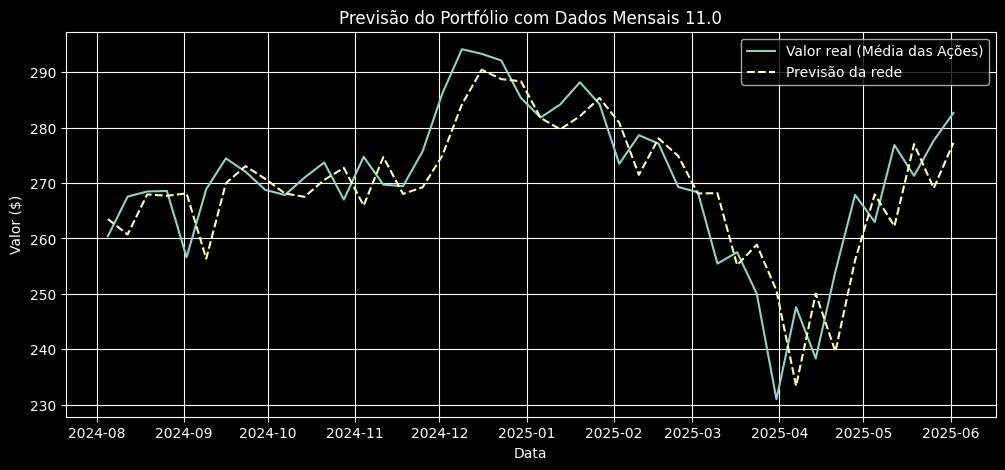

44 semanas de dados, logo 11.0 Meses


In [1053]:

dates = df.index[-len(y_test_real):]  # pega as datas correspondentes ao conjunto teste


plt.figure(figsize=(12, 5))
plt.style.use('dark_background')
plt.plot(dates, y_test_real, label='Valor real (Média das Ações)') if len(TICKERS) >= 2 else None
# for ticker in TICKERS:
#   plt.plot(dates, df[ticker][-len(y_test_real):].values, label=ticker) if len(TICKERS) > 1 else None
plt.plot(dates, predictions_real, label='Previsão da rede', linestyle='--')
plt.title(f'Previsão do Portfólio com Dados Mensais {len(dates)/4}')
plt.xlabel('Data')
plt.ylabel('Valor ($)')
plt.legend()
plt.grid(True)
plt.show()


dates[0], dates[-1]

print(f"{len(dates)} semanas de dados, logo {len(dates)/4} Meses") # Lembrar da Subtração com Window Size


**Sugestão de Decisão de Compra/Espera/Venda das Ações**

In [1054]:
threshold = 0.015  # 1.5% de variação para decidir compra/venda

index_max = np.argmax(y_test_real)
index_min = np.argmin(y_test_real)

valor_max_real = y_test_real[index_max]
valor_max_previsto = predictions_real[index_max]
data_max = dates[index_max]

valor_min_real = y_test_real[index_min]
valor_min_previsto = predictions_real[index_min]
data_min = dates[index_min]

print(f"📈 Ação mais cara (Portfólio - {' e '.join(TICKERS)}):")
print(f"Data: {data_max.strftime('%Y-%m-%d')}")
print(f"Valor real   : ${valor_max_real:.2f}")
print(f"Valor previsto: ${valor_max_previsto:.2f}")
erro = valor_max_real - valor_max_previsto
print(f"Erro de: ${abs(erro):.2f}\n")

print(f"📉 Ação mais barata (Portfólio - {' e '.join(TICKERS)}):")
print(f"Data: {data_min.strftime('%Y-%m-%d')}")
print(f"Valor real   : ${valor_min_real:.2f}")
print(f"Valor previsto: ${valor_min_previsto:.2f}")
erro2 = valor_min_real - valor_min_previsto
print(f"Erro de: ${abs(erro2):.2f}\n")

decisoes = []
for i in range(len(predictions_real) - 1):
    atual = predictions_real[i]
    futuro = predictions_real[i + 1]
    delta = (futuro - atual) / atual

    if i == 0:
        delta = 0
        decisao = "🟢 Compra"
    else:
        if delta > threshold:
            decisao = "🟢 Comprar"
        elif delta < -threshold:
            decisao = "🔴 Vender"
        else:
            decisao = "⚪️ Esperar"

    decisoes.append((dates[i].strftime('%Y-%m-%d'), atual, delta * 100, decisao))

print(f"💰 De Acordo com o modelo de Previsão:\n")
print(f"{'Data':<12} {'Valor Atual':<14} {'Δ%':<8} {'Decisão'}")
for data, atual, delta, decisao in decisoes:
    print(f"{data:<12} ${atual:<13.2f} {delta:>+6.2f}%   {decisao}")

capital_inicial = 1000.0
dinheiro = capital_inicial
acoes = 0
historico_compras = []

for i, (data_str, atual, delta_pct, decisao) in enumerate(decisoes):
    delta = delta_pct / 100

    if i == 0 and dinheiro >= atual:
        maximo_acoes = int(dinheiro / atual)
        if maximo_acoes > 0:
            custo = maximo_acoes * atual
            dinheiro -= custo
            acoes += maximo_acoes
            historico_compras.append((data_str, maximo_acoes, atual))
        continue

    if decisao == "🟢 Comprar" and dinheiro >= atual:
        excesso = delta - threshold
        fator = excesso / threshold  # quanto acima do threshold
        fator = max(1.0, fator)  # no mínimo 1 ação

        fator = min((excesso / threshold), 5)  # fator de escala, limitado a 5
        orcamento = dinheiro * (fator / 5)  # usar parte proporcional do dinheiro
        maximo_acoes = int(orcamento / atual)  # limitar para evitar exageros

        if maximo_acoes > 0 and dinheiro >= maximo_acoes:
            custo = maximo_acoes * atual
            dinheiro -= custo
            acoes += maximo_acoes
            historico_compras.append((data_str, maximo_acoes, atual))

    elif decisao == "🔴 Vender" and acoes > 0:
        dinheiro += acoes * atual
        historico_compras.append((data_str, -acoes, atual))  # registro da venda
        acoes = 0

preco_final = predictions_real[-1]
valor_final = dinheiro + acoes * preco_final
lucro = valor_final - capital_inicial

if historico_compras:
    print("\n📋 Registro de Transações:")
    print(f"{'Data':<12} {'Ações':<10} {'Valor Unitário':<15} {'Total'}")
    for data, qtd, valor in historico_compras:
        total = abs(qtd) * valor
        tipo = "Compra" if qtd > 0 else "Venda"
        print(f"{data:<12} {qtd:<10} ${valor:<14.2f} ${total:.2f} ({tipo})")
else:
    print("\n⚠️ Nenhuma transação foi realizada.")

print("\n📊 Resultados finais da simulação:")
print(f"Dinheiro restante (Não investido): ${dinheiro:.2f}")
print(f"Ações restantes: {acoes}")
print(f"Preço final da ação: ${preco_final:.2f}")
print(f"Valor final da carteira: ${valor_final:.2f}")
print(f"Lucro total: ${lucro:.2f} - {(lucro/capital_inicial)*100:.2f}%")


📈 Ação mais cara (Portfólio - AAPL e MSFT e GOOGL):
Data: 2024-12-09
Valor real   : $294.16
Valor previsto: $284.20
Erro de: $9.96

📉 Ação mais barata (Portfólio - AAPL e MSFT e GOOGL):
Data: 2025-03-31
Valor real   : $230.97
Valor previsto: $250.61
Erro de: $19.64

💰 De Acordo com o modelo de Previsão:

Data         Valor Atual    Δ%       Decisão
2024-08-05   $263.49         +0.00%   🟢 Compra
2024-08-12   $260.71         +2.78%   🟢 Comprar
2024-08-19   $267.94         -0.09%   ⚪️ Esperar
2024-08-26   $267.70         +0.16%   ⚪️ Esperar
2024-09-02   $268.14         -4.40%   🔴 Vender
2024-09-09   $256.35         +5.32%   🟢 Comprar
2024-09-16   $269.98         +1.14%   ⚪️ Esperar
2024-09-23   $273.06         -0.84%   ⚪️ Esperar
2024-09-30   $270.76         -0.97%   ⚪️ Esperar
2024-10-07   $268.12         -0.23%   ⚪️ Esperar
2024-10-14   $267.51         +1.14%   ⚪️ Esperar
2024-10-21   $270.57         +0.80%   ⚪️ Esperar
2024-10-28   $272.73         -2.49%   🔴 Vender
2024-11-04   $265.93

**Passos Futuro**

In [1055]:
last_window = portfolio_scaled[-WINDOW_SIZE:].tolist()
future_predictions_scaled = []

for _ in range(FUTURE_STEPS):
    input_array = np.array(last_window[-WINDOW_SIZE:]).reshape(1, WINDOW_SIZE, 1) # Como é LSTM, redimensiona para o formato esperado
    next_pred = model.predict(input_array)[0, 0]
    future_predictions_scaled.append(next_pred)
    last_window.append(next_pred)

future_predictions_real = [p * std + mean for p in future_predictions_scaled] # Desnormaliza as previsões para escala original

predictions_str = ', '.join([str(p) for p in future_predictions_real])
print(f"\nValores Previstos: {np.array(predictions_str)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Valores Previstos: 280.40746725181606, 277.9807462623294, 276.2556936019204, 274.758728377742


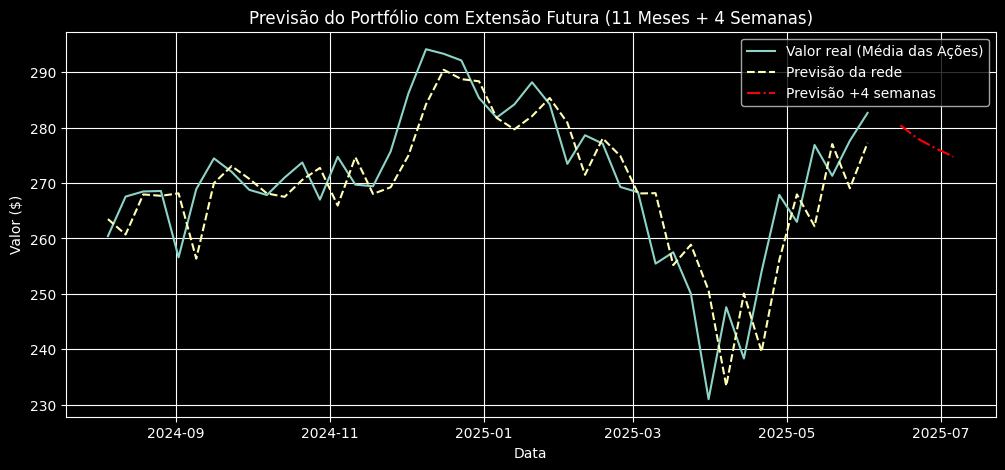

In [1056]:
plt.figure(figsize=(12, 5))
plt.style.use('dark_background')
plt.plot(df.index[-len(y_test_real):], y_test_real, label='Valor real (Média das Ações)')
plt.plot(df.index[-len(predictions_real):], predictions_real, label='Previsão da rede', linestyle='--')
plt.plot(pd.date_range(df.index[-1], periods=FUTURE_STEPS+1, freq='W')[1:], future_predictions_real, label=f'Previsão +{FUTURE_STEPS} semanas', linestyle='-.', color="red")
plt.title(f'Previsão do Portfólio com Extensão Futura (11 Meses + {FUTURE_STEPS} Semanas)')
plt.xlabel('Data')
plt.ylabel('Valor ($)')
plt.legend()
plt.grid(True)
plt.show()

####Esse gráfico mostra a performance do modelo LSTM ao longo dos **3 anos**, e não só no conjunto de teste.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


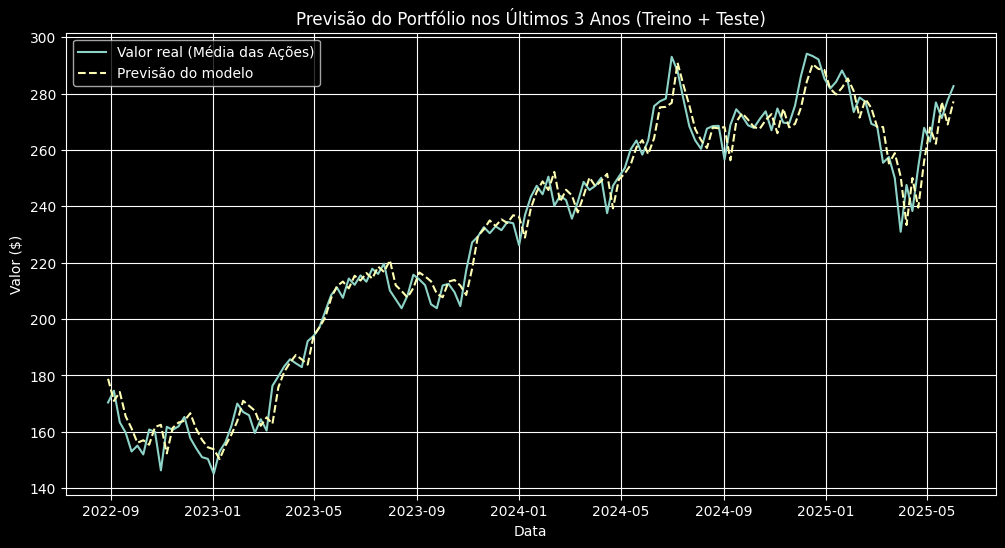

145

In [1057]:
all_predictions = model.predict(X).flatten() # Passa todas as janelas de entrada (X) para o modelo LSTM e depois transforma um array 2D (shape: (n, 1)) para 1D
all_predictions_real = all_predictions * std + mean
all_y_real = y * std + mean

all_dates = df.index[WINDOW_SIZE:]  # compensar janela deslizante

plt.figure(figsize=(12, 6))
plt.style.use('dark_background')
plt.plot(all_dates, all_y_real, label='Valor real (Média das Ações)')
plt.plot(all_dates, all_predictions_real, label='Previsão do modelo', linestyle='--')
plt.title('Previsão do Portfólio nos Últimos 3 Anos (Treino + Teste)')
plt.xlabel('Data')
plt.ylabel('Valor ($)')
plt.legend()
plt.grid(True)
plt.show()

len(all_dates)

**Visualização do Loss**

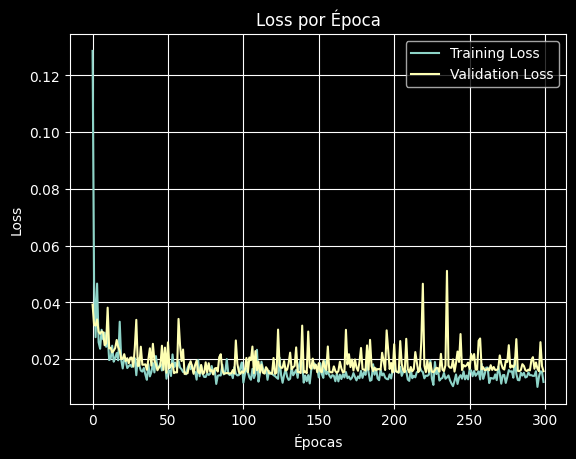

In [1058]:
if history:
    loss_data = history.history
elif os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, "r") as f:
        loss_data = json.load(f)
else:
    loss_data = None

if loss_data:
    plt.plot(loss_data['loss'], label='Training Loss')
    plt.plot(loss_data['val_loss'], label='Validation Loss')
    plt.title('Loss por Época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ Nenhum histórico de loss encontrado.")

**Inicializar PCA**

In [1059]:
scaler = StandardScaler()
if 'Portfolio' in df.columns:
  df = df.drop("Portfolio",axis=1)
scaled_df = scaler.fit_transform(df)

pca = PCA()
pca.fit(scaled_df)
explained_variance = pca.explained_variance_ratio_ # Variância explicada por componente, quanto da variância total cada componente principal explica

len(scaled_df), explained_variance,scaled_df, pca.components_, df

(157,
 array([0.9303217 , 0.04965777, 0.02002053]),
 array([[-1.54755033, -1.37847797, -0.89867706],
        [-1.71706472, -1.44889245, -1.02811518],
        [-1.40968745, -1.18450686, -0.67918421],
        [-1.49277132, -1.2915805 , -0.97676523],
        [-1.2459567 , -1.18503502, -0.63477658],
        [-1.15069925, -1.32929287, -0.87883348],
        [-1.03140084, -1.28129467, -1.00374473],
        [-0.77515254, -1.0125584 , -0.73249891],
        [-0.68872248, -0.98394392, -0.69545217],
        [-0.47602137, -0.86526778, -0.55982939],
        [-0.49369739, -0.94122068, -0.70382804],
        [-0.7344547 , -1.17186084, -0.92514141],
        [-0.97246976, -1.33082885, -1.0053556 ],
        [-0.92492714, -1.2198285 , -0.91515493],
        [-1.12819975, -1.48041447, -1.16803863],
        [-1.13642887, -1.57053575, -1.29882931],
        [-1.50914557, -1.63687188, -1.39837193],
        [-1.45154645, -1.61916464, -1.30076221],
        [-1.50365965, -1.69422174, -1.36905701],
        [-1.23273

**Componentes principais (pesos das ações)**

In [1060]:
components = pca.components_
pca_df = pd.DataFrame(components.T,
                      columns=[f'PC{i+1}' for i in range(len(components))],
                      index=df.columns)

**Mostrar a contribuição de cada ação no 1ª componente principal**

In [1061]:
print("Contribuição de cada ação no 1º componente principal (PC1):")
print(pca_df['PC1'].sort_values(ascending=False))

Contribuição de cada ação no 1º componente principal (PC1):
GOOGL    0.585721
MSFT     0.576985
AAPL     0.569227
Name: PC1, dtype: float64


**Mostrar a contribuição de cada ação no 2ª componente principal**

In [1062]:
if 'PC2' in pca_df.columns:
  print("Contribuição de cada ação no 2º componente principal (PC2):")
  print(pca_df['PC2'].sort_values(ascending=False))

Contribuição de cada ação no 2º componente principal (PC2):
AAPL     0.787028
GOOGL   -0.185170
MSFT    -0.588472
Name: PC2, dtype: float64


In [1063]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(df.columns))], index=df.columns)

def interpretar_pca(loadings):
    analises = []

    pc1_abs = loadings['PC1'].abs().sort_values(ascending=False)
    mais_influente = pc1_abs.index[0]
    menos_influente = pc1_abs.index[-1]

    analises.append(f"💡 Análise PC1\n\n⏩ O componente principal 1 (PC1) representa a direção de maior variância dos dados, ou seja, a combinação linear que mais resume a variação dos preços das ações.\n\n🔀 {mais_influente} é o ativo que mais influencia, enquanto {menos_influente} interfere menos.")

    if 'PC2' in loadings.columns:
        pc2 = loadings['PC2']
        positivos = pc2[pc2 > 0].sort_values(ascending=False)
        negativos = pc2[pc2 < 0].sort_values()

        if not positivos.empty and not negativos.empty:
            analises.append(
                f"\n💡 Análise PC2\n\n"
                f"⏩ {positivos.index[0]} = {positivos.iloc[0]:.3f}: contribui positivamente para PC2.\n\n"
                f"⏩ {' e '.join(negativos.index)} negativos: vão na direção oposta de {positivos.index[0]} neste componente.\n\n"
                f"🔁 Isso sugere que quando {positivos.index[0]} se desvia da média geral, "
                f"{' e '.join(negativos.index)} tendem a ir na direção contrária."
            )

    return "\n\n".join(analises)

print(interpretar_pca(loadings))

💡 Análise PC1

⏩ O componente principal 1 (PC1) representa a direção de maior variância dos dados, ou seja, a combinação linear que mais resume a variação dos preços das ações.

🔀 GOOGL é o ativo que mais influencia, enquanto AAPL interfere menos.


💡 Análise PC2

⏩ AAPL = 0.787: contribui positivamente para PC2.

⏩ MSFT e GOOGL negativos: vão na direção oposta de AAPL neste componente.

🔁 Isso sugere que quando AAPL se desvia da média geral, MSFT e GOOGL tendem a ir na direção contrária.
